In [ ]:
# 뉴스기사 요약해보기

In [1]:
# 주요 라이브러리 확인 

!pip install --upgrade summa
!pip install --upgrade nltk #3.9.1

In [2]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.7.1+cu118
2.3.0
1.2.0


In [6]:
# Step 1. 데이터 수집하기
# 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_headlines_more.csv)를 사용하세요.

# sunnysai12345/News_headlines
# 아래의 코드로 데이터를 다운로드할 수 있어요.

In [4]:
import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_headlines/master/news_headlines_more.csv", filename="news_headlines_more.csv")
data = pd.read_csv('news_headlines_more.csv', encoding='iso-8859-1')

FileNotFoundError: [Errno 2] No such file or directory: 'news_headlines_more.csv'

In [6]:
import os
print(os.getcwd()) # 현재 작업 디렉터리 출력

/home/jovyan/work/workplace/AIFFEL_quest_rs/Exploration/Quest06


In [7]:
import pandas as pd

# 올바른 파일 이름으로 수정
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [8]:
data.sample(10)

,headlines,text
82239,Beech Beech Mein song from Jab Harry Met Sejal...,"Beech Beech Mein, a new song from the Shah Ruk..."
57818,MP death penalty bill for child rapists regres...,Human Rights NGO Amnesty International India o...
70693,There should be more women employees in school...,"HRD Minister Prakash Javadekar on Monday said,..."
56436,Parliament's 2017 Winter Session to be shortes...,"This year's Winter Session of the Parliament, ..."
63908,WhatsApp rolls out feature to delete sent mess...,WhatsApp has started rolling out a feature tha...
24573,"My primary work is art, not to earn trophies: ...","Actor-writer Saurabh Shukla, who was honoured ..."
94674,PMO helps man file FIR after he writes to Modi,The Prime Minister's Office helped a man file ...
2785,Coach sexually abused me since I was 17: 21-yr...,South Korea's double Olympic short track gold ...
39387,Poster of 'Sanju' featuring Dia as Dutt's wife...,"A new poster of Sanjay Dutt's biopic 'Sanju', ..."
89750,4 teachers suspended for asking a NEET entrant...,At least four Kerala school teachers were on T...


In [9]:
# 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.

# 추상적 요약을 하는 경우에는 text를 본문, 
# headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다. 
# 추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

In [10]:
#Step 2. 데이터 전처리하기 (추상적 요약)

# 분석단계 
# 정제단계
# 정규화와 불용어 제거 
    #불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민
# 데이터셋 분리 
# 인코딩 과정


In [11]:
#분석

#데이터 갯수 확인
print('전체 샘플수 :', (len(data)))

#데이터 중복 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())


전체 샘플수 : 98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [12]:
#정제

#중복 제거 
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [13]:
#nul 값확인
print(data.isnull().sum())
 #확인 결과 nul값 없음

headlines    0
text         0
dtype: int64


In [14]:
# 정규화를 위한 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [17]:
# 데이터 전처리 함수 준비
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (길이가 짧은 headlines에서는 의미가 왜곡될 수 있으니 불용어 미제거 )
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [18]:
#!pip install lxml

In [19]:
# 전처리 결과 샘플링 확

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [20]:
# 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. 
# (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 
# 또한 특수문자가 제거되면서 영어만 남았다.

# 이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 
# 이때, text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행함. 
# 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

In [21]:
# 원문(text)데이터 전처리

# 'clean_text'라는 이름의 빈 리스트를 생성합니다.
clean_text = []

# 'data' 데이터프레임의 'text' 열에 있는 모든 문장에 대해 반복 작업을 수행합니다.
for sentence in data['text']:
    # 각 문장을 'preprocess_sentence()' 함수에 넣어 전처리하고, 그 결과를 'clean_text' 리스트에 추가합니다.
    clean_text.append(preprocess_sentence(sentence))

# 전처리 작업이 완료된 'clean_text' 리스트의 첫 5개 항목을 출력합니다.
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [22]:
# 요약문(headlines) 데이터 전처리(불용어 미제거)

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [23]:
# nul 값확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [24]:
#데이터셋 분리

    # 훈련데이터와 테스트데이터 나누기
        # 학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줌.
    
    # 샘플의 최대 길이 정하기
        # text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


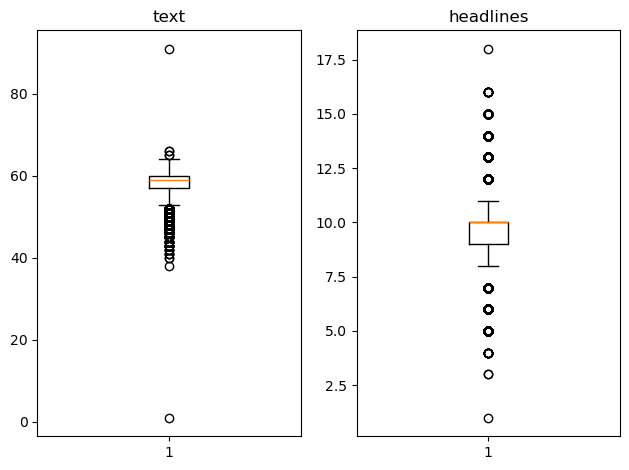

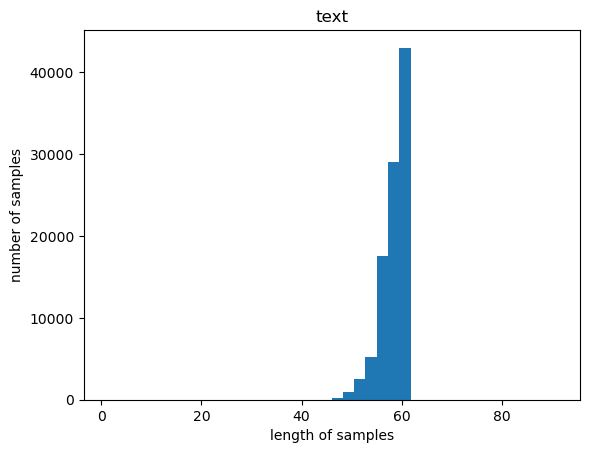

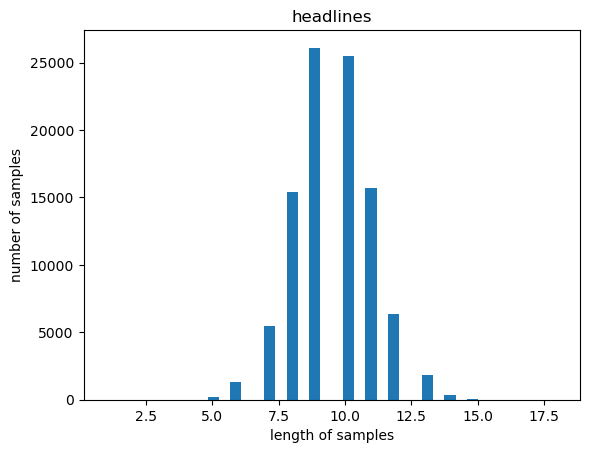

In [25]:
# 길이 분포 출력
import matplotlib.pyplot as plt
import numpy as np

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
# 텍스트의 최소 길이 : 1
# 텍스트의 최대 길이 : 91
# 텍스트의 평균 길이 : 58.23813542090281
# 요약의 최소 길이 : 1
# 요약의 최대 길이 : 18
# 요약의 평균 길이 : 9.553660024400163

# text
# 최소 길이 1 최대 길이는 91 평균길이는 58.23로 차이가 비교적 크지 않은 듯.
# 그러나 박스 플롯 그래프로 보면 대분이 50~60사이 분포된 것으로 보인다.
# 70을 넘는 값과 20 미만의 값은 이상치(outlier)로 판단할 수 있음.

# headlines
# 최소 길이 1 최대 길이는 18 평균길이는 9.58.
# 박스플롯은 text에 비해서는 분포가 안정적이지만 대부분의 데이터가 9~ 10단어사이에 분포하고 있다.
# 길이가 5미만이거나 12이상인 값들은 이상치로 판단할 수 있음.


In [27]:
#text IQR(사분위 범위)과 이상치 개수
text_Q1 = np.quantile(text_len, 0.25)
text_Q3 = np.quantile(text_len, 0.75)
text_IQR = text_Q3 - text_Q1

text_lower_bound = text_Q1 - 1.5 * text_IQR
text_upper_bound = text_Q3 + 1.5 * text_IQR

print(f"text IQR: {text_IQR}")
print(f"Lower bound for text outliers: {text_lower_bound}")
print(f"Upper bound for text outliers: {text_upper_bound}")

# 특이값 수 확인
text_outliers = [length for length in text_len if length < text_lower_bound or length > text_upper_bound]
print(f"Number of text outliers: {len(text_outliers)}")

# 임의의 제거 기준
text_max_len = 70
text_min_len = 40

# 제거 대상 수 확인
remove_text_outliers = [length for length in text_len if length < text_min_len or length > text_max_len]
print(f"Number of remove text outliers: {len(remove_text_outliers)}")


#headlines IQR(사분위 범위)과 이상치 개수

headlines_Q1 = np.quantile(headlines_len, 0.25)
headlines_Q3 = np.quantile(headlines_len, 0.75)
headlines_IQR = headlines_Q3 - headlines_Q1

headlines_lower_bound = headlines_Q1 - 1.5 * headlines_IQR
headlines_upper_bound = headlines_Q3 + 1.5 * headlines_IQR

print(f"headlines_IQR: {headlines_IQR}")
print(f"Lower bound for headlines_outliers: {headlines_lower_bound}")
print(f"Upper bound for headlines_outliers: {headlines_upper_bound}")

# 특이값 확인
headlines_outliers = [length for length in headlines_len if length < headlines_lower_bound or length > headlines_upper_bound]
print(f"Number of headlines outliers: {len(headlines_outliers)}")

# 임의의 제거 기준
headlines_max_len = 12
headlines_min_len = 5

# 제거 대상 수 확인
remove_headlines_outliers = [length for length in headlines_len if length < headlines_min_len or length > headlines_max_len]
print(f"Number of remove headlines outliers: {len(remove_headlines_outliers)}")

text IQR: 3.0
Lower bound for text outliers: 52.5
Upper bound for text outliers: 64.5
Number of text outliers: 3635
Number of remove text outliers: 3
headlines_IQR: 1.0
Lower bound for headlines_outliers: 7.5
Upper bound for headlines_outliers: 11.5
Number of headlines outliers: 15630
Number of remove headlines outliers: 2295


In [28]:
#text 
 #IQR: 3.0: 데이터의 중간 50%가 3.0이라는 매우 좁은 범위(단어 3개정도의 길이 차이가 있을 뿐) 내에 분포하고 있음.
 #이는 데이터가 중앙값을 중심으로 매우 밀집되어 있음을 나타냄.
 #데이터 이상치 표준 규칙에 의한 수치 52.5<x<64.5를 참고하였으나 대부분이 중앙에 집중된 데이터 분포로 보수적으로 제거 기준을 잡음
 #이상치 제거 기준을 40이하 70이상의 길이로 잡았을 때 제거되는 수는 단지 3개

#headlines
 #데이터 이상치 표준 규칙에 의한 수치 7.5<x<11.5를 참고하였으나 대부분이 중앙에 집중된 데이터 분포로 보수적으로 제거 기준을 잡음
 #이상치 제거 기준을 5이하 12이상의 길이로 잡았을 때 제거되는 수는 단지 2295개

In [29]:
#이상치 제거 

# 'data' 데이터프레임에서 'text' 열의 단어 수가 'text_min_len'보다 크거나 같은 행 & 'text_max_len'보다 작거나 같은 행만 선택하여 
 #'data'에 다시 할당합니다.
remove_text_len = data['text'].apply(lambda x: len(x.split()))
data = data[(remove_text_len >= text_min_len) & (remove_text_len <= text_max_len)]

# 'data' 데이터프레임에서 'headlines' 열의 단어 수가 'headlines_min_len'보다 크거나 같은 행 & 'headlines_max_len'보다 작거나 같은 행만 선택하여
 #'data'에 다시 할당합니다.
remove_headlines_len = data['headlines'].apply(lambda x: len(x.split()))
data = data[(remove_headlines_len >= headlines_min_len) & (remove_headlines_len <= headlines_max_len)]

# 위의 두 조건을 모두 만족하는 최종 샘플의 개수를 출력합니다.
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96063


In [30]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
import pandas as pd

# 데이터프레임의 열 너비를 무제한으로 설정
pd.set_option('display.max_colwidth', None)

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",sostoken Delhi techie wins free food from Swiggy for one year on CRED,Delhi techie wins free food from Swiggy for one year on CRED eostoken
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.",sostoken New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand end Rohit Sharma-led India's 12-match winning streak eostoken
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.",sostoken Aegon life iTerm insurance plan helps customers save tax,Aegon life iTerm insurance plan helps customers save tax eostoken
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,"Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. ""It would have been better if the authorities would have served the notice first if any and then publicised this,"" reads a press release issued on behalf of Rahat. The statement further called the allegation ""bizarre"".",sostoken Rahat Fateh Ali Khan denies getting notice for smuggling currency,Rahat Fateh Ali Khan denies getting notice for smuggling currency eostoken
7,Govt directs Alok Verma to join work 1 day before his retirement,"Weeks after ex-CBI Director Alok Verma told the Department of Personnel and Training to consider him retired, the Home Ministry asked him to join work on the last day of his fixed tenure as Director on Thursday. The ministry directed him to immediately join as DG, Fire Services, the post he was transferred to after his removal as CBI chief.",sostoken Govt directs Alok Verma to join work 1 day before his retirement,Govt directs Alok Verma to join work 1 day before his retirement eostoken


In [31]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [32]:
#훈련 데이터와 테스트 데이터 분리

# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56202 50438 60124 ... 80947 56916 35150]


In [33]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [34]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19212


In [35]:
# 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76851
훈련 레이블의 개수 : 76851
테스트 데이터의 개수 : 19212
테스트 레이블의 개수 : 19212


In [36]:
# 정수 인코딩
 # 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [37]:
# 훈련 데이터 단어 집합
 
#원문에 해당되는 encoder_input_train 단어 집합을 만들기.
#Keras의 토크나이저를 사용하여, 입력된 훈련 데이터로부터 단어 집합 생성
from collections import Counter


def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [38]:
# 빈도수 낮은 데이터 제거 

 # 빈도수 7회 미만인 단어들 비중 확인

threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 245311
등장 빈도가 6번 이하인 희귀 단어의 수: 205707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 39604
단어 집합에서 희귀 단어의 비율: 83.85559555013839
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.15012639891207


In [39]:
src_vocab_size = 39000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)
print('=3')

=3


In [40]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여
# 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 
# 현재 단어 집합의 크기를 39,000으로 제한함으로 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는.

In [41]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[2, 515, 532, 9, 165, 12, 20, 85, 1667, 6419, 1350, 4900, 9, 2759, 2456, 2457, 6483, 7, 9884, 6, 3441, 12401, 1677, 4486, 7690, 8919, 24, 66, 3798, 583, 5, 364, 6, 502, 8, 8773, 410, 5193, 40, 136, 4, 114, 22, 228, 783, 1055, 185, 13, 102, 29, 12095, 3279, 3, 344, 2, 270, 135, 2825, 1340], [4, 77, 4929, 21559, 806, 25, 373, 5, 2, 1673, 6, 4, 4597, 6950, 1524, 5, 3113, 40, 32, 16059, 17, 21560, 1, 2, 6950, 10932, 806, 25, 575, 4, 4929, 10932, 855, 79, 5, 2, 1673, 13, 25, 373, 2654, 101, 2, 1524, 123, 25, 27, 225, 3406, 3517, 1, 4, 8644, 895, 924, 4, 2138, 7, 4, 1542], [83, 1010, 157, 2714, 4744, 10, 357, 76, 970, 5, 2, 362, 3, 1399, 1520, 735, 165, 200, 3, 14409, 223, 1579, 477, 2, 750, 51, 10, 357, 76, 970, 5, 2, 72, 3, 373, 26, 1047, 599, 40, 136, 22, 2, 55, 657, 1078, 768, 4, 278, 566, 1031, 5, 83, 7, 1145, 2, 51, 3, 1627, 970]]
[[4, 681, 6, 2, 2468, 1600, 424, 6373, 13185, 13, 2, 3990, 6, 2, 424, 19784, 21, 20088, 1700, 5, 2, 3527, 9115, 7, 42, 5, 792, 23, 1221, 478, 2, 107, 8230, 

In [42]:
# headlines 데이터에 대해서도 동일한 작업 수행. 
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산.

def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)
print('=3')

=3


In [43]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31782
등장 빈도가 5번 이하인 희귀 단어의 수: 21029
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10753
단어 집합에서 희귀 단어의 비율: 66.16638348750865
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.745147385358386


In [44]:
tar_vocab_size = 10000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 1329, 4, 2034, 6676, 957, 4496, 9, 2599, 1, 5, 1137, 314], [2, 3280, 1, 518, 4, 195, 5, 19, 1638, 8, 4418, 1744], [2, 111, 40, 593, 1251, 4, 586, 174, 700, 7061], [2, 8046, 843, 5250, 508, 11, 4587, 17, 4662], [2, 958, 435, 2702, 1, 43, 11, 620]]
target
decoder  [[1329, 4, 2034, 6676, 957, 4496, 9, 2599, 1, 5, 1137, 314, 3], [3280, 1, 518, 4, 195, 5, 19, 1638, 8, 4418, 1744, 3], [111, 40, 593, 1251, 4, 586, 174, 700, 7061, 3], [8046, 843, 5250, 508, 11, 4587, 17, 4662, 3], [958, 435, 2702, 1, 43, 11, 620, 3]]


In [45]:
# decoder_input_train과 decoder_target_train에는 숫자 10,000이 넘는 숫자들은 존재하지 않음.
# 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었을 가능성이 있음.
  
# 요약문에서 길이가 0이 된 샘플들의 인덱스를 확인. 
# 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 
# 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않음. 
# 따라서 길이가 0이 된 요약문의 실제 길이는 1로 나옴.
 # --> 예제의 경우 특정 단어수 이하를 제거하지 않음으로 이런 상황이 발생할 수 있으나. 본프로젝트에서는 제거함으로 발생하지않음
 # 그러나 확인 차원에서 진행

# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 
# 각각 drop_train과 drop_test에 라는 변수에 저장후 삭제.

In [46]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76851
훈련 레이블의 개수 : 76851
테스트 데이터의 개수 : 19212
테스트 레이블의 개수 : 19212


In [47]:
#패딩하기

from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

print('=3')

=3


In [48]:
# 모델 설계

In [49]:
# 함수형 API를 이용해서 인코더를 설계.
 # 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의
 # hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
 # 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수로 이해. 
 # 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아님.

# 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임.
# hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 
# 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음.
# 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줌


import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [50]:
# 디코더 설계
# 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일
# 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함.


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [51]:
# 디코더의 출력층을 설계.

# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(39000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [52]:
# 디코더의 출력층에서는 headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제
# 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용.

# 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq
# 디코더의 출력층을 설계를 어텐션 메커니즘으로 변경.

# 어텐션 메커니즘
# 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 
# 어텐션 기능을 구현하고 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요.

# 참고로 여기서 사용하는 어텐션 함수는 Luong 스타일의 어텐션입니다. 

# 아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [53]:
#어텐션 모델 
# 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 
#어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동.

class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(39000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [54]:
# 9. 모델 훈련하기


In [55]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 2

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [56]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [57]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 36.56it/s]


Epoch 1/50 | Train Loss: 6.9787 | Val Loss: 6.6779


Epoch 2/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 34.76it/s]


Epoch 2/50 | Train Loss: 6.5758 | Val Loss: 6.3511


Epoch 3/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.24it/s]


Epoch 3/50 | Train Loss: 6.1834 | Val Loss: 5.9265


Epoch 4/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 32.63it/s]


Epoch 4/50 | Train Loss: 5.7314 | Val Loss: 5.5190


Epoch 5/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.36it/s]


Epoch 5/50 | Train Loss: 5.3578 | Val Loss: 5.2292


Epoch 6/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.21it/s]


Epoch 6/50 | Train Loss: 5.0549 | Val Loss: 5.0027


Epoch 7/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.10it/s]


Epoch 7/50 | Train Loss: 4.8012 | Val Loss: 4.8199


Epoch 8/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.25it/s]


Epoch 8/50 | Train Loss: 4.5804 | Val Loss: 4.6623


Epoch 9/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.36it/s]


Epoch 9/50 | Train Loss: 4.3819 | Val Loss: 4.5379


Epoch 10/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 32.95it/s]


Epoch 10/50 | Train Loss: 4.2021 | Val Loss: 4.4246


Epoch 11/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.07it/s]


Epoch 11/50 | Train Loss: 4.0393 | Val Loss: 4.3277


Epoch 12/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.21it/s]


Epoch 12/50 | Train Loss: 3.8919 | Val Loss: 4.2486


Epoch 13/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.23it/s]


Epoch 13/50 | Train Loss: 3.7554 | Val Loss: 4.1822


Epoch 14/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.23it/s]


Epoch 14/50 | Train Loss: 3.6318 | Val Loss: 4.1334


Epoch 15/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.17it/s]


Epoch 15/50 | Train Loss: 3.5158 | Val Loss: 4.0805


Epoch 16/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.22it/s]


Epoch 16/50 | Train Loss: 3.4095 | Val Loss: 4.0414


Epoch 17/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 32.99it/s]


Epoch 17/50 | Train Loss: 3.3104 | Val Loss: 4.0045


Epoch 18/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.28it/s]


Epoch 18/50 | Train Loss: 3.2210 | Val Loss: 3.9770


Epoch 19/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.13it/s]


Epoch 19/50 | Train Loss: 3.1308 | Val Loss: 3.9593


Epoch 20/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 32.85it/s]


Epoch 20/50 | Train Loss: 3.0512 | Val Loss: 3.9504


Epoch 21/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.26it/s]


Epoch 21/50 | Train Loss: 2.9747 | Val Loss: 3.9303


Epoch 22/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 32.92it/s]


Epoch 22/50 | Train Loss: 2.9006 | Val Loss: 3.9235


Epoch 23/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.27it/s]


Epoch 23/50 | Train Loss: 2.8320 | Val Loss: 3.9213


Epoch 24/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.18it/s]


Epoch 24/50 | Train Loss: 2.7662 | Val Loss: 3.9248


Epoch 25/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.11it/s]


Epoch 25/50 | Train Loss: 2.7016 | Val Loss: 3.9160


Epoch 26/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.06it/s]


Epoch 26/50 | Train Loss: 2.6445 | Val Loss: 3.9234


Epoch 27/50 [Validation]: 100%|██████████| 76/76 [00:02<00:00, 33.22it/s]

Epoch 27/50 | Train Loss: 2.5866 | Val Loss: 3.9196
Early stopping triggered at epoch 27
CPU times: user 13min 33s, sys: 2.33 s, total: 13min 36s
Wall time: 13min 34s


In [58]:
#시각화

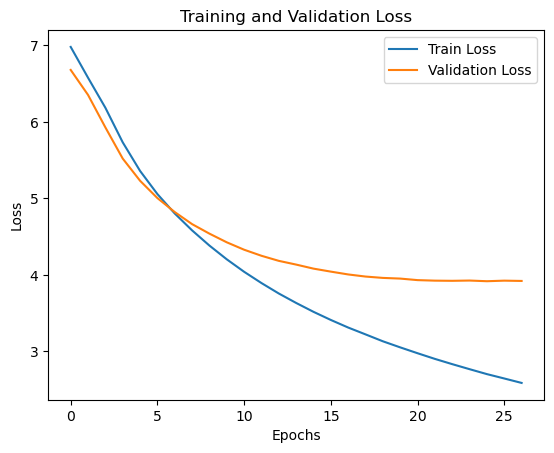

In [59]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [60]:
# 10. 인퍼런스 모델 구현하기
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 
# 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [61]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [62]:
# seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다름 
#따라서 모델 설계를 별개로 진행해야 함

# 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 
# 인코더와 디코더를 엮은 통짜 모델 하나만 필요.

# 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 
# 인퍼런스를 위한 모델 설계를 별도로 해줌. 
# 이때는 인코더 모델과 디코더 모델을 분리해서 설계.

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

print('=3')

=3


In [64]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [65]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence
print("=3")

=3


In [66]:
# 11. 모델 테스트
# 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인
# 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 필요

# 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 
#headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외.


In [67]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

print('=3')

=3


In [68]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교


In [69]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : speaking at the 16th hindustan times leadership summit actor turned politician kamal haasan said i don t want to see any one colour <UNK> the flag stating that the idea is <UNK> he added we ve respected religion and we ve given it a place in our flag i want to see my tricolour maintain its texture
실제 요약 : don t want one colour to <UNK> tricolour kamal haasan
예측 요약 :  uk uk on last last a attack on calls if calls


원문 : two nuns who worked at a california catholic school have admitted stealing about 500 000 and using it to gamble in las vegas the nuns who are said to be best friends took funds from an account holding tuition fees and donations the church said they expressed deep remorse over their actions adding no criminal charges would be brought against them
실제 요약 : nuns steal 500 000 from school to <UNK> in las vegas
예측 요약 :  me may a a a a a a says year 20


원문 : india captain virat kohli who was given a bottle of champagne for being named man of the match in trent bridge test

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_5733/4248792236.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  last attack uk m uk on firm on firm on calls


원문 : us based southwest airlines has filed a lawsuit against a website that alerted flyers when the fares of its flights fell the website used data from the southwest website to enable customers to rebook their tickets at cheaper prices the airline has claimed the site violated its trademarks computer fraud and the terms and conditions of its website
실제 요약 : airline sues website that offered alerts about falling fares
예측 요약 :  modi video on last a a a a a 2 on


원문 : china is planning to build an ocean observatory in the maldives for military purposes according to reports located in <UNK> the observatory will also give china access to an important shipping route in the indian ocean both china and the maldives had finalised an official agreement called the protocol on establishment of joint ocean observation station last year
실제 요약 : china may build military <UNK> in maldives reports
예측 요약 :  last 4 attack 6 attack its firm on firm

In [70]:
# 추출적 요약 해보기
# 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법 진행

#패키지 Summa의 추출적 요약을 위한 모듈인 summarize 사용


In [71]:
!pip install summa

In [72]:
# summarize 사용하기
    # Summa의 summarize()의 인자로 사용되는 값
    # text (str) : 요약할 테스트.
    # ratio (float, optional) - 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    # words (int or None, optional) - 출력에 포함할 단어 수. 
        #만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
    # split (bool, optional) - True면 문장 list / False는 조인(join)된 문자열을 반환

# Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
# 원문을 바로 입력으로 넣을 수 있음. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 
# 원문의 0.005%만을 출력하도록 설정했어요.

In [73]:
print('Summary:')
print(summarize(text, ratio=0.01))

Summary:


NameError: name 'summarize' is not defined